#Introduction
This python code is for the first part of IN3060/INM460 Computer Vision (PRD2 A 2023/24) Coursework.

I will implement three different combinations of feature descriptors and classfiers, including "HOG + SVM", "SIFT + MLP", and "CNN".

## Google Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV2024-CW-230048952-LYHuang'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'Code', 'CW_Dataset', 'Video', 'test_function.ipynb']


## Library import

In [3]:
# for accessing and preprocessing the dataset
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split

# HOG
from skimage.feature import hog
from skimage import exposure
import numpy as np

# SIFT
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans

# SVM
from sklearn import svm, metrics
import warnings
warnings.filterwarnings("ignore", "Precision and F-score are ill-defined*")

from joblib import dump, load

# MLPs
from sklearn.neural_network import MLPClassifier

# CNNs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms
torch.cuda.manual_seed(46)
torch.manual_seed(46)

# Model Performance and images output
import matplotlib.pyplot as plt
import random

%matplotlib inline

# Access the provided dataset

Two dataset will be loading in this section. One is from provided datasets, another is video from internet.

*Unzipped dataset adapted from Lab 6 code*

In [4]:
# Unzipped dataset
# the path of zip file
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab
!rm CV2024_CW_Dataset.zip

Functions to read and preprocess images and labels

In [5]:
# Functions to read images and labels stored as dictionary with filename
def read_labels(path):
    labels = {}
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(os.path.join(path, file), 'r') as f:
                labels[file.split('.')[0]] = f.read()
    return labels

def read_images(path):
    images = {}
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            img = cv2.imread(os.path.join(path, file))
            images[file.split('.')[0]] = img
    return images

# Function to preporcess images
def preprocess_images(images):
    processed_images = []
    for image in images:
        resized_image = cv2.resize(image, (32, 32)) # Resize image to 32x32
        normalized_image = resized_image.astype('float32') / 255.0 # Convert image to float32 and normalize to range [0, 1]
        processed_images.append(normalized_image)
    return processed_images

Loading provided dataset in train folder

In [6]:
# filepath for train dataset
image_train_dir = 'train/images'
label_train_dir = 'train/labels'

# Read train labels and images
labels_train = read_labels(label_train_dir)
images_train = read_images(image_train_dir)

# Store two lists for images and labels
train_images = []
train_labels = []
for filename, label in labels_train.items():
    if filename in images_train:
        train_images.append(images_train[filename])
        train_labels.append(label)

# Preprocess images
train_images_transform = preprocess_images(train_images)

print(Counter(train_labels))

Counter({'1': 1940, '0': 376, '2': 78})


Here, we split train data into training and validation subset with 80/20 percentage. Since dataset is unbalanced itself, we also use stratify to make sure split equally.

*Adopt from Lab 6 code*

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images_transform, train_labels, test_size=0.2,
    shuffle=True, stratify=train_labels, random_state=46)

print(len(X_train), len(X_val))

1915 479


#  Implement a series of image classification models to perform FCD

## HOG + SVM

Extract HOG features

*This part is adopted from Lab 5 code and [scikit-image library](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog).*

In [ ]:
def HOG_extract(images):

    # Extract HOG features from images
    images_hog = []
    for image in images:
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, channel_axis=2)
        hog_image = exposure.equalize_hist(hog_image)
        images_hog.append(features)

    # Flatten the HOG features
    images_hog = np.array(images_hog)

    return images_hog

In [ ]:
# Extract HOG features for training data
X_train_hog = HOG_extract(X_train)

# Extract HOG features for validation data
X_val_hog = HOG_extract(X_val)

Experienced different SVM classifier with different C and evaluate its performance.

*The code is adopted from Lab 6 and [sklearn.svm.SVC library](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)*

In [ ]:
# Function of SVM classifier
def SVM_classifier(kernel, C_value, X_train, y_train):
    # Train SVM classifier
    svm_classifier = svm.SVC(kernel=kernel, C = C_value, random_state=46)
    svm_classifier.fit(X_train, y_train)

    return svm_classifier

# Evaluate with trained classifier
def classifier_evaluate(classifier, X_test, y_test):
    # Predict on validation data
    y_pred = classifier.predict(X_test)

    # Evaluate performance
    accuracy = metrics.accuracy_score(y_test, y_pred)
    weighted_f1 = metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
    report = metrics.classification_report(y_test, y_pred)

    # print results
    print("Accuracy:", accuracy)
    print("Weighted F1-score:", weighted_f1)
    print("Classification Report:\n", report)


In [ ]:
# Train SVM classifier {‘rbf’, ‘poly’} with C_value {0.01, 0.1, 1, 10}

svm_classifier_rbf_001 = SVM_classifier('rbf', 0.01, X_train_hog, y_train)
print("HOG + SVM with kernel = 'rbf', and C value = 0.01")
classifier_evaluate(svm_classifier_rbf_001, X_val_hog, y_val)

svm_classifier_rbf_01 = SVM_classifier('rbf', 0.1, X_train_hog, y_train)
print("HOG + SVM with kernel = 'rbf', and C value = 0.1")
classifier_evaluate(svm_classifier_rbf_01, X_val_hog, y_val)

svm_classifier_rbf_1 = SVM_classifier('rbf', 1, X_train_hog, y_train)
print("HOG + SVM with kernel = 'rbf', and C value = 1")
classifier_evaluate(svm_classifier_rbf_1, X_val_hog, y_val)

svm_classifier_rbf_10 = SVM_classifier('rbf', 10, X_train_hog, y_train)
print("HOG + SVM with kernel = 'rbf', and C value = 10")
classifier_evaluate(svm_classifier_rbf_10, X_val_hog, y_val)

svm_classifier_poly_001 = SVM_classifier('poly', 0.01, X_train_hog, y_train)
print("HOG + SVM with kernel = 'poly', and C value = 0.01")
classifier_evaluate(svm_classifier_poly_001, X_val_hog, y_val)

svm_classifier_poly_01 = SVM_classifier('poly', 0.1, X_train_hog, y_train)
print("HOG + SVM with kernel = 'poly', and C value = 0.1")
classifier_evaluate(svm_classifier_poly_01, X_val_hog, y_val)

svm_classifier_poly_1 = SVM_classifier('poly', 1, X_train_hog, y_train)
print("HOG + SVM with kernel = 'poly', and C value = 1")
classifier_evaluate(svm_classifier_poly_1, X_val_hog, y_val)

svm_classifier_poly_10 = SVM_classifier('poly', 10, X_train_hog, y_train)
print("HOG + SVM with kernel = 'poly', and C value = 10")
classifier_evaluate(svm_classifier_poly_10, X_val_hog, y_val)

HOG + SVM with kernel = 'rbf', and C value = 0.01
Accuracy: 0.8100208768267223
Weighted F1-score: 0.7250013845646327
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.81      1.00      0.90       388
           2       0.00      0.00      0.00        16

    accuracy                           0.81       479
   macro avg       0.27      0.33      0.30       479
weighted avg       0.66      0.81      0.73       479

HOG + SVM with kernel = 'rbf', and C value = 0.1
Accuracy: 0.8100208768267223
Weighted F1-score: 0.7250013845646327
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.81      1.00      0.90       388
           2       0.00      0.00      0.00        16

    accuracy                           0.81       479
   macro avg       0.27      0.33      0.30       479
weighted avg

With highest weighted F1-score as the selected model in this combination.

HOG + SVM with kernel = 'rbf' and C value = 10 is choosen. Now store the classifier for the test dataset.

In [ ]:
HOGwSVM_classifier = svm_classifier_rbf_10

# Store the classifier
dump(HOGwSVM_classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOGwSVM_classifier.joblib'))

print(HOGwSVM_classifier)

SVC(C=10, random_state=46)


## SIFT + MLP

*This section is adopted from Lab 6 code.*

Using SIFT and apply k-means to create 30 groups as input neurones in MLPs

Extract descriptors with SIFT in training set

In [ ]:
# SIFT detector
sift = cv2.SIFT_create()

# lists for feature descriptors and labels
des_list = []
y_train_list = []

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Append list of descriptors and label into lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

# Convert to array
des_array = np.vstack(des_list)

# Number of codewords
k = 30

# Use MiniBatchKMeans for clustering
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto', random_state=46).fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

In [ ]:
# Store kmeans model
dump(kmeans, os.path.join(GOOGLE_DRIVE_PATH, 'Models/kmeans_SIFT.joblib'))

['drive/My Drive/CV2024-CW-230048952-LYHuang/Models/kmeans_SIFT.joblib']

Extract descriptors with SIFT in validation set and assign into related kmeans group

In [ ]:
def SIFT_feature(images, labels, kmeans):
    hist_list = []

    for i in range(len(images)):
        img = img_as_ubyte(color.rgb2gray(images[i]))
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            hist = np.zeros(30)
            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            hist_list.append(hist)

        else:
            hist_list.append(None)

    # Remove images with no descriptors
    idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
    hist_list = [hist_list[i] for i in idx_not_empty]
    labels_list = [labels[i] for i in idx_not_empty]
    hist_array = np.vstack(hist_list)

    return hist_array, labels_list

In [ ]:
# Extract SIFT and assign into related kmeans groups on validation set
hist_array_val, y_val_list = SIFT_feature(X_val, y_val, kmeans)

Training MLPs.

*This part is adopted from [sklearn.neural_network.MLPClassifier library](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).*

In [ ]:
# Function for MLP classifier
def MLP_Classifier(X_train, y_train, hidden_size1, hidden_size2=None, verbose=False):

    if hidden_size2 == None:
        classifier = MLPClassifier(hidden_layer_sizes=(hidden_size1,), max_iter=500, alpha=1e-4,
                      solver='sgd', verbose=verbose, random_state=46, learning_rate_init=.1)

    else:
        classifier = MLPClassifier(hidden_layer_sizes=(hidden_size1, hidden_size2), max_iter=500, alpha=1e-4,
                      solver='sgd', verbose=verbose, random_state=46, learning_rate_init=.1)

    # Fit classifier
    classifier.fit(X_train, y_train)

    return classifier

In [ ]:
# Experience with one hidden layer and different neurone sizes in MLP classifier
MLP_classifier_1_15 = MLP_Classifier(hist_array, y_train_list, 15)
print("SIFT + MLP with one hidden layer and 15 neurones")
classifier_evaluate(MLP_classifier_1_15, hist_array_val, y_val_list)

MLP_classifier_1_30 = MLP_Classifier(hist_array, y_train_list, 30)
print("SIFT + MLP with one hidden layer and 30 neurones")
classifier_evaluate(MLP_classifier_1_30, hist_array_val, y_val_list)

MLP_classifier_1_60 = MLP_Classifier(hist_array, y_train_list, 60)
print("SIFT + MLP with one hidden layer and 60 neurones")
classifier_evaluate(MLP_classifier_1_60, hist_array_val, y_val_list)

MLP_classifier_1_120 = MLP_Classifier(hist_array, y_train_list, 120)
print("SIFT + MLP with one hidden layer and 120 neurones")
classifier_evaluate(MLP_classifier_1_120, hist_array_val, y_val_list)

SIFT + MLP with one hidden layer and 15 neurones
Accuracy: 0.8138075313807531
Weighted F1-score: 0.7808080361703448
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.27      0.34        74
           1       0.85      0.95      0.90       388
           2       0.00      0.00      0.00        16

    accuracy                           0.81       478
   macro avg       0.44      0.41      0.41       478
weighted avg       0.76      0.81      0.78       478

SIFT + MLP with one hidden layer and 30 neurones
Accuracy: 0.8117154811715481
Weighted F1-score: 0.7844697928379937
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.31      0.37        74
           1       0.86      0.94      0.90       388
           2       0.00      0.00      0.00        16

    accuracy                           0.81       478
   macro avg       0.43      0.42      0.42       478
weighted avg 

In [ ]:
# Experience with two hidden layers and different neurone sizes in MLP classifier
MLP_classifier_2_15 = MLP_Classifier(hist_array, y_train_list, 15, 15)
print("SIFT + MLP with two hidden layer and 15 neurones")
classifier_evaluate(MLP_classifier_2_15, hist_array_val, y_val_list)

MLP_classifier_2_30 = MLP_Classifier(hist_array, y_train_list, 30, 30)
print("SIFT + MLP with two hidden layer and 30 neurones")
classifier_evaluate(MLP_classifier_2_30, hist_array_val, y_val_list)

MLP_classifier_2_60 = MLP_Classifier(hist_array, y_train_list, 60, 60)
print("SIFT + MLP with two hidden layer and 60 neurones")
classifier_evaluate(MLP_classifier_2_60, hist_array_val, y_val_list)

MLP_classifier_2_120 = MLP_Classifier(hist_array, y_train_list, 120, 120)
print("SIFT + MLP with two hidden layer and 120 neurones")
classifier_evaluate(MLP_classifier_2_120, hist_array_val, y_val_list)

SIFT + MLP with two hidden layer and 15 neurones
Accuracy: 0.8075313807531381
Weighted F1-score: 0.7935236481118585
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.45      0.44        74
           1       0.88      0.91      0.89       388
           2       0.00      0.00      0.00        16

    accuracy                           0.81       478
   macro avg       0.44      0.45      0.44       478
weighted avg       0.78      0.81      0.79       478

SIFT + MLP with two hidden layer and 30 neurones
Accuracy: 0.797071129707113
Weighted F1-score: 0.7832212276892113
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.41      0.40        74
           1       0.87      0.90      0.89       388
           2       0.00      0.00      0.00        16

    accuracy                           0.80       478
   macro avg       0.42      0.44      0.43       478
weighted avg  

With highest weighted F1-score as the selected model in this combination.

SIFT + MLP with two hidden layers and 15 neurones is choosen. Now store the classifier for the model test part.

In [ ]:
SIFTwMLP_classifier = MLP_classifier_2_15

# Store the trained classifier
dump(SIFTwMLP_classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/SIFTwMLP_classifier.joblib'))

print(SIFTwMLP_classifier)

MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate_init=0.1, max_iter=500,
              random_state=46, solver='sgd')


## CNN

Convert training and validation dataset into tensor form

*The coding is adopted from [pytorch tutorial datasets part](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).*

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

def data_tensor(images, labels):
    data_means = [0.485, 0.456, 0.406]
    data_stds = [0.229, 0.224, 0.225]

    # transform into tensor and normalize with means and stds above
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=data_means, std=data_stds)
    ])

    # convert str into int for labels
    label_int = [int(label) for label in labels]

    # Convert label_int into tensors
    label_tensor = torch.tensor(label_int, dtype=torch.long)

    # Create dataset
    dataset = CustomDataset(images, label_tensor, transform=transform)

    return dataset

In [9]:
# create train and val datasets
train_dataset = data_tensor(X_train, y_train)
val_dataset = data_tensor(X_val, y_val)

# random split 90/10 percent in train_dataset to training/monitoring set to avoid overfitting
monitoring_size = int(0.1 * len(train_dataset))
training_size = len(train_dataset) - monitoring_size

training_subset, monitoring_subset = random_split(train_dataset, [training_size, monitoring_size])

# create dataloader in training_subse, monitoring_subset, val_dataset
batch_size = 32

train_loader = DataLoader(training_subset, batch_size=batch_size, shuffle=True)
monitor_loader = DataLoader(monitoring_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

*The coding related CNNs training and evaluating are adopted from Lab 7 and [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html).*

Defining CNN architecture

In [10]:
## CNNs architectures
# CNNs with one convolutional layer
class CNN_1(nn.Module):
    def __init__(self, hidden_size, kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(hidden_size * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# CNNs with two conventional layers
class CNN_2(nn.Module):
    def __init__(self, hidden_size, kernel_size):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(hidden_size * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def CNN_model(layer, hidden_size, kernel_size, train_loader, monitor_loader):

    torch.manual_seed(46) # set the random seed

    # Decide the convolutional layer
    if layer == 1:
        model = CNN_1(hidden_size, kernel_size)
    elif layer == 2:
        model = CNN_2(hidden_size, kernel_size)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    fail_max = 5  # Number of epochs to wait if no improvement
    min_loss = float('inf')  # Initialize minimum loss
    fail_counter = 0  # Counter the epochs without improvement

    # Train the CNNs
    num_epochs = 25
    for epoch in range(num_epochs):
        model.train() # Training network
        running_train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()


        model.eval() # evaluate with monitor set
        running_val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(monitor_loader, 0):
                inputs, labels = data
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

        # Calculate average losses
        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(monitor_loader)

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check for early stopping
        if avg_val_loss < min_loss:
            min_loss = avg_val_loss
            fail_counter = 0
        else:
            fail_counter += 1
            if fail_counter >= fail_max:
                print(f"Early stopping triggered in epochs {epoch + 1}")
                break

    return model

In [12]:
# Function of evaluation on validation set

def CNN_evaluation(model, data_loader):

    # store true labels and predicted labels
    true_labels = []
    pred_labels = []

    # evaluation on data_loader
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Convert tensors to numpy arrays and append to lists
            true_labels.extend(labels.numpy())
            pred_labels.extend(predicted.numpy())

    # Evaluate performance
    accuracy = metrics.accuracy_score(true_labels, pred_labels)
    weighted_f1 = metrics.precision_recall_fscore_support(true_labels, pred_labels, average='weighted')[2]
    report = metrics.classification_report(true_labels, pred_labels)

    # print results
    print("Accuracy:", accuracy)
    print("Weighted F1-score:", weighted_f1)
    print("Classification Report:\n", report)

In [ ]:
# CNNs model with one convolutional layer
CNN_1_6_3 = CNN_model(1, 6, 3, train_loader, monitor_loader)
print("CNN with one convolutional layer of 6 filters and kernel size = 3")
CNN_evaluation(CNN_1_6_3, val_loader)

CNN_1_6_5 = CNN_model(1, 6, 5, train_loader, monitor_loader)
print("CNN with one convolutional layer of 6 filters and kernel size = 5")
CNN_evaluation(CNN_1_6_5, val_loader)

CNN_1_12_3 = CNN_model(1, 12, 3, train_loader, monitor_loader)
print("CNN with one convolutional layer of 12 filters and kernel size = 3")
CNN_evaluation(CNN_1_12_3, val_loader)

CNN_1_12_5 = CNN_model(1, 12, 5, train_loader, monitor_loader)
print("CNN with one convolutional layer of 12 filters and kernel size = 5")
CNN_evaluation(CNN_1_12_5, val_loader)

Early stopping triggered in epochs 10
CNN with one conventional layer of 6 filters and kernel size = 3
Accuracy: 0.9311064718162839
Weighted F1-score: 0.9191890750199524
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85        75
           1       0.95      0.98      0.97       388
           2       0.33      0.06      0.11        16

    accuracy                           0.93       479
   macro avg       0.71      0.63      0.64       479
weighted avg       0.91      0.93      0.92       479

Early stopping triggered in epochs 10
CNN with one conventional layer of 6 filters and kernel size = 5
Accuracy: 0.9331941544885177
Weighted F1-score: 0.9185889437984446
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86        75
           1       0.95      0.98      0.97       388
           2       0.00      0.00      0.00        16

    accuracy 

In [ ]:
# CNNs model with two convolutional layers
CNN_2_6_3 = CNN_model(2, 6, 3, train_loader, monitor_loader)
print("CNN with two convolutional layer of 6 filters and kernel size = 3")
CNN_evaluation(CNN_2_6_3, val_loader)

CNN_2_6_5 = CNN_model(2, 6, 5, train_loader, monitor_loader)
print("CNN with two convolutional layer of 6 filters and kernel size = 5")
CNN_evaluation(CNN_2_6_5, val_loader)

CNN_2_12_3 = CNN_model(2, 12, 3, train_loader, monitor_loader)
print("CNN with two convolutional layer of 12 filters and kernel size = 3")
CNN_evaluation(CNN_2_12_3, val_loader)

CNN_2_12_5 = CNN_model(2, 12, 5, train_loader, monitor_loader)
print("CNN with two convolutional layer of 12 filters and kernel size = 5")
CNN_evaluation(CNN_2_12_5, val_loader)

Early stopping triggered in epochs 19
CNN with two conventional layer of 6 filters and kernel size = 3
Accuracy: 0.9227557411273486
Weighted F1-score: 0.9117918705340889
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82        75
           1       0.95      0.98      0.96       388
           2       0.25      0.06      0.10        16

    accuracy                           0.92       479
   macro avg       0.67      0.62      0.63       479
weighted avg       0.91      0.92      0.91       479

Early stopping triggered in epochs 20
CNN with two conventional layer of 6 filters and kernel size = 5
Accuracy: 0.941544885177453
Weighted F1-score: 0.9376791921637208
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        75
           1       0.97      0.97      0.97       388
           2       0.62      0.31      0.42        16

    accuracy  

With highest weighted F1-score as the selected model in this combination.

CNN with with two convolutional layers of 12 filters and kernel size = 5 is choosen. Now store the classifier for the model test part.

In [ ]:
CNN_classifier = CNN_2_6_5

# Store trained model
torch.save(CNN_classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_classifier.pth'))
print(CNN_classifier)

CNN_2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


## Selected model performance on test dataset

In [ ]:
# Load the models
HOGwSVM_classifier = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOGwSVM_classifier.joblib'))
SIFTwMLP_classifier = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/SIFTwMLP_classifier.joblib'))
kmeans = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/kmeans_SIFT.joblib'))
CNN_classifier = torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_classifier.pth'))

Loading provided dataset in test file

In [ ]:
## filepath for test dataset
image_test_dir = os.path.join(GOOGLE_DRIVE_PATH, "CW_Dataset/test/images")
label_test_dir = os.path.join(GOOGLE_DRIVE_PATH, "CW_Dataset/test/labels")

# Read test labels and images
labels_test = read_labels(label_test_dir)
images_test = read_images(image_test_dir)

# Store two lists for images and labels
test_images = []
test_labels = []
for filename, label in labels_test.items():
    if filename in images_test:
        test_images.append(images_test[filename])
        test_labels.append(label)

# Preprocess images
test_images_transform = preprocess_images(test_images)

print(Counter(test_labels))

Counter({'1': 388, '0': 51, '2': 19})


HOG + SVM on image classification task: SVC(C=10, random_state=46)
Accuracy: 0.8624454148471615
Weighted F1-score: 0.8511112026585372
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.47      0.50        51
           1       0.90      0.95      0.92       388
           2       0.67      0.21      0.32        19

    accuracy                           0.86       458
   macro avg       0.70      0.54      0.58       458
weighted avg       0.85      0.86      0.85       458



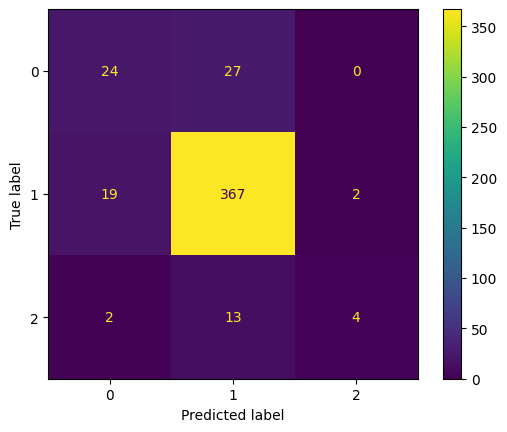

In [ ]:
## HOG + SVM
# Extract HOG features for test dataset
X_test_hog = HOG_extract(test_images_transform)
print("HOG + SVM on image classification task:", HOGwSVM_classifier)
classifier_evaluate(HOGwSVM_classifier, X_test_hog, test_labels)

y_pred = HOGwSVM_classifier.predict(X_test_hog)
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
plt.show()

SIFT + MLP on image classification task: MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate_init=0.1, max_iter=500,
              random_state=46, solver='sgd')
Accuracy: 0.8183807439824945
Weighted F1-score: 0.8025101049993963
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.41      0.39        51
           1       0.88      0.91      0.90       387
           2       0.00      0.00      0.00        19

    accuracy                           0.82       457
   macro avg       0.42      0.44      0.43       457
weighted avg       0.79      0.82      0.80       457



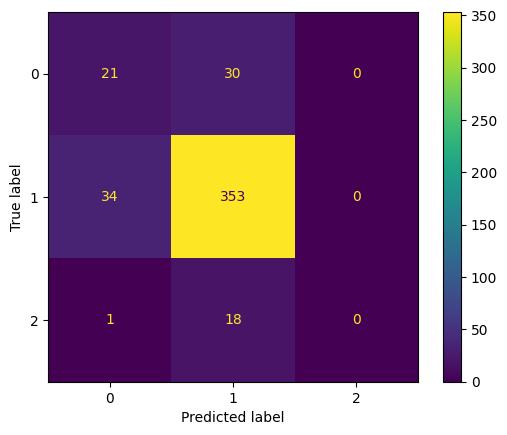

In [ ]:
## SIFT + MLP
# Extract SIFT and assign into related kmeans groups on test dataset
hist_array_test, y_test_list = SIFT_feature(test_images_transform, test_labels, kmeans)
print("SIFT + MLP on image classification task:", SIFTwMLP_classifier)
classifier_evaluate(SIFTwMLP_classifier, hist_array_test, y_test_list)

y_pred = SIFTwMLP_classifier.predict(hist_array_test)
metrics.ConfusionMatrixDisplay.from_predictions(y_test_list, y_pred)
plt.show()

CNN on image classification task: CNN_2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Accuracy: 0.9454148471615721
Weighted F1-score: 0.9454923803894969
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89        51
           1       0.98      0.97      0.97       388
           2       0.56      0.53      0.54        19

    accuracy                           0.95       458
   macro avg       0.79      0.81      0.80       458
weighted avg       0.95      0.95      0.95       458



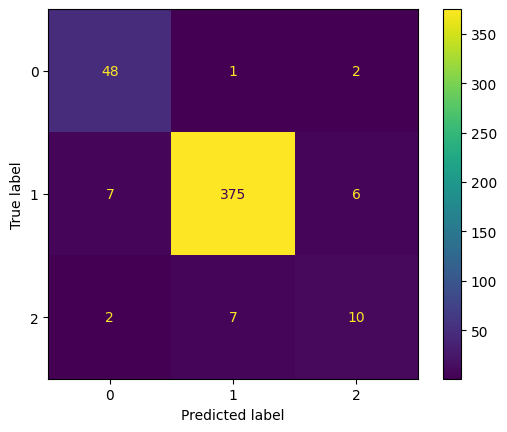

In [ ]:
## CNN
# Convert test dataset into tensor form
test_dataset = data_tensor(test_images_transform, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("CNN on image classification task:", CNN_classifier)
CNN_evaluation(CNN_classifier, test_loader)

# store true labels and predicted labels
true_labels = []
pred_labels = []

# evaluation on test_loader
CNN_classifier.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN_classifier(images)
        _, predicted = torch.max(outputs.data, 1)

        # Convert tensors to numpy arrays and append to lists
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

metrics.ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels)
plt.show()

In [ ]:
# Create a dictionary and store indices for each class
class_indices = {}

for i, label in enumerate(test_labels):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

# Select two image indices from each class
selected_indices = []
for label, indices in class_indices.items():
    # Randomly select two indices from the list of indices for each class
    selected_indices.extend(random.sample(indices, 2))

selected_indices

[165, 127, 283, 206, 324, 36]

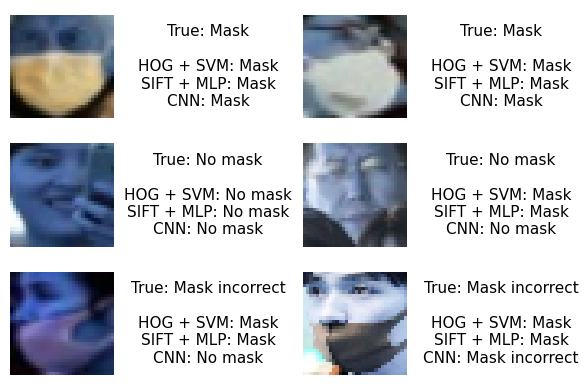

In [ ]:
label_text = { '0': "No mask", '1': "Mask", '2': "Mask incorrect"}

# Plot the images with true and predicted labels
plt.figure(figsize=(6, 4))

for i, idx in enumerate(selected_indices, 1):
    image = test_images_transform[idx]  # Retrieve image
    true_label = test_labels[idx]  # True label
    true_label_text = label_text.get(true_label, "Unknown")

    # predict with HOG + SVM
    hog_features = HOG_extract([image])  # Extract HOG features
    HOGwSVM_predicted_label = HOGwSVM_classifier.predict(hog_features)[0]  # Predict label
    HOGwSVM_predicted = label_text.get(HOGwSVM_predicted_label, "Unknown")

    # predict with SIFT + MLP
    sift = cv2.SIFT_create() # Initiate SIFT detector
    # SIFT feature
    hist_list = []
    img = img_as_ubyte(color.rgb2gray(image))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(30)
        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

    if hist_list != [None]:
        hist_array = np.vstack(hist_list)
        SIFTwMLP_predicted_label = SIFTwMLP_classifier.predict(hist_array)[0]  # Predict label
        SIFTwMLP_predicted = label_text.get(SIFTwMLP_predicted_label)

    else:
        SIFTwMLP_predicted = 'No SIFT feature'

    # predict with CNN
    # convert image to tensor and normalise with means and stds
    data_means = [0.485, 0.456, 0.406]
    data_stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=data_means, std=data_stds)
    ])
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Prediction
    CNN_classifier.eval()

    with torch.no_grad():
        output = CNN_classifier(img_tensor)
        _, CNN_predicted_label = torch.max(output, 1)
        CNN_predicted_label = CNN_predicted_label.item()  # Convert to Python scalar

    CNN_predicted = label_text.get(str(CNN_predicted_label))

    # Plot the image on the left side
    plt.subplot(3, 4, i*2-1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the text on the right side
    plt.subplot(3, 4, i*2)
    plt.text(0.5, 0.5, f'True: {true_label_text}\n\nHOG + SVM: {HOGwSVM_predicted}\nSIFT + MLP: {SIFTwMLP_predicted}\nCNN: {CNN_predicted}',
             ha='center', va='center', fontsize=11)
    plt.axis('off')

plt.tight_layout()
plt.show()